In [ ]:
!pip install --quiet catboost optuna pycol tf_slim dtale --pre pycaret

In [ ]:
%cd /content/drive/MyDrive/Colab Data/Churn Data

/content/drive/MyDrive/Colab Data/Churn Data


In [ ]:
import math
import dtale
import pickle
import optuna
import random
import pycaret
import numpy as np
import pandas as pd
import catboost as cb
import tensorflow as tf
import category_encoders as ce
import matplotlib.pyplot as plt

from imblearn.under_sampling import TomekLinks

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score

In [ ]:
from GANsample import GAN

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)

In [ ]:
SEED = 42
seed_everything(SEED)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Data/Churn Data/Churn_Modelling.csv')
df.head()


#df['balance_to_salary_ratio'] = df['Balance'] / df['EstimatedSalary']
#df.replace([np.inf, -np.inf], 0, inplace=True)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
dtale.show(df)

In [ ]:
x = df.iloc[:,2:13]
y = df.iloc[:,13]

# FEATURE GENERATION
x['avg_transaction_amt'] = x['Balance'] / x['NumOfProducts']
x['credit_card_age'] = x['Age'] - x['Tenure']
x['balance_to_salary_ratio'] = x['Balance'] / x['EstimatedSalary']
x['product_diversity'] = (x['NumOfProducts'] > 1).astype(int)
x['age_squared'] = x['Age'] ** 2
x['balance_credit_ratio'] = x['Balance'] / x['CreditScore']
x['product_per_tenure'] = x['NumOfProducts'] / x['Tenure']
x['credit_card_utilization'] = x['HasCrCard'] * x['Balance']
x['credit_score_age_ratio'] = x['CreditScore'] / x['Age']
x['log_balance'] = np.log(x['Balance'])
x['log_salary'] = np.log(x['EstimatedSalary'])
x['LocationGender'] = x['Geography'] + '_' + x['Gender']

bins = [17, 24, 34, 44, 54, 64, 74, 84, 94]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84', '85-94']
x['AgeGroup'] = pd.cut(x['Age'].values, bins=bins, labels=labels)

# Divide CreditScore into categories
credit_score_bins = [0, 500, 700, 850]
credit_score_labels = ['low', 'medium', 'high']
x['CreditScoreCategory'] = pd.cut(df['CreditScore'], bins=credit_score_bins, labels=credit_score_labels)


x.replace([np.inf, -np.inf], 0, inplace=True)

for c in x.columns:
  if x[c].dtype=='object' or x[c].dtype=='string':
    x[c] = x[c].astype('category')


gender_ohe = pd.get_dummies(x["Gender"], drop_first=True)
country_ohe = pd.get_dummies(x["Geography"], drop_first=True)
LocationGender_ohe = pd.get_dummies(x["LocationGender"], drop_first=True)
AgeGroup_ohe = pd.get_dummies(x["AgeGroup"], drop_first=True)
csc_ohe = pd.get_dummies(x["CreditScoreCategory"], drop_first=True)

x.drop(["Gender", "Geography", "LocationGender", "AgeGroup", "CreditScoreCategory"], axis=1, inplace=True)
x = pd.concat([x, gender_ohe, country_ohe, LocationGender_ohe, AgeGroup_ohe, csc_ohe], axis=1)


colnames = x.columns
categorical_columns = ['Geography', 'Gender', 'LocationGender', 'AgeGroup', 'CreditScoreCategory']

In [ ]:
x.info()

In [ ]:
# TRAIN-TEST SPLIT
X_tr, X_val, y_tr, y_val = train_test_split(x, y, test_size=0.3,
    random_state=SEED, stratify=y)


categorical_features_indices = np.where(pd.DataFrame(X_tr).dtypes == 'category')[0]

In [ ]:
# Leave One Out encoding
encoder = ce.LeaveOneOutEncoder(return_df=True)
X_train_loo = encoder.fit_transform(X_tr['Surname'], y_tr)
X_tr["Surname"] = X_train_loo

X_test_loo = encoder.transform(X_val['Surname'], y_val)
X_val["Surname"] = X_test_loo


# MinMax Scaling for GAN sampling
scale_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'EstimatedSalary', 'avg_transaction_amt',
       'credit_card_age', 'balance_to_salary_ratio', 'product_diversity',
       'age_squared', 'balance_credit_ratio', 'product_per_tenure',
       'credit_card_utilization', 'credit_score_age_ratio', 'log_balance',
       'log_salary']

scaler = MinMaxScaler()

X_tr[scale_cols] = scaler.fit_transform(X_tr[scale_cols])
X_val[scale_cols] = scaler.transform(X_val[scale_cols])


# Removing Tomek Links
under = TomekLinks(sampling_strategy='majority')
X_tr, y_tr = under.fit_resample(X_tr, y_tr)

In [ ]:
LogReg = LogisticRegression(random_state=SEED)
LogReg.fit(X_tr, y_tr)

lr_pred = LogReg.predict_proba(X_val)

In [ ]:
base_pred = (lr_pred[:,1] > 0.2620000000000001)

In [ ]:
print(classification_report(y_val, base_pred))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87      2389
           1       0.52      0.76      0.62       611

    accuracy                           0.81      3000
   macro avg       0.73      0.79      0.75      3000
weighted avg       0.85      0.81      0.82      3000



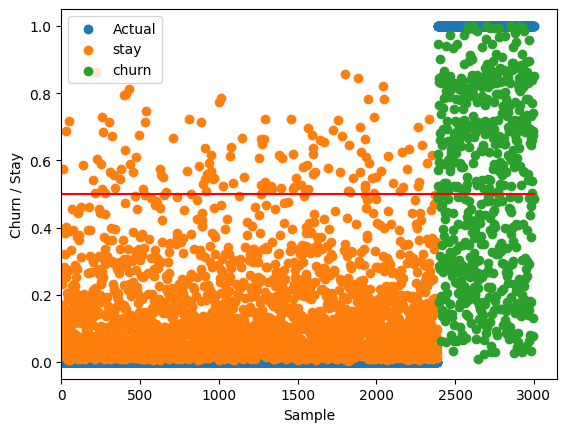

In [ ]:
pred = LogReg.predict_proba(X_val)
df_test = X_val.join(y_val)
df_test['prob'] = pred[:,1]

df = df_test.sort_values('Exited')
df = df.reset_index(drop=True)

stay = df[df['Exited']==0]
churn = df[df['Exited']==1]

m = pd.crosstab(index=df_test['Exited'], columns=np.where(df_test['prob'] > 0.5, 1, 0))
cost = (np.sum(np.sum(np.array([[0, 100], [500, 100]]) * m)))

plt.figure()
plt.scatter(df.index,df['Exited'],label='Actual')
plt.scatter(stay.index,stay['prob'],label='stay')
plt.scatter(churn.index,churn['prob'],label='churn')
plt.plot([df.index.min(),df.index.max()],[0.5,0.5],color='r')
plt.xlim(left=0)
plt.xlabel('Sample')
plt.ylabel('Churn / Stay')
plt.legend(loc=2)
plt.show()

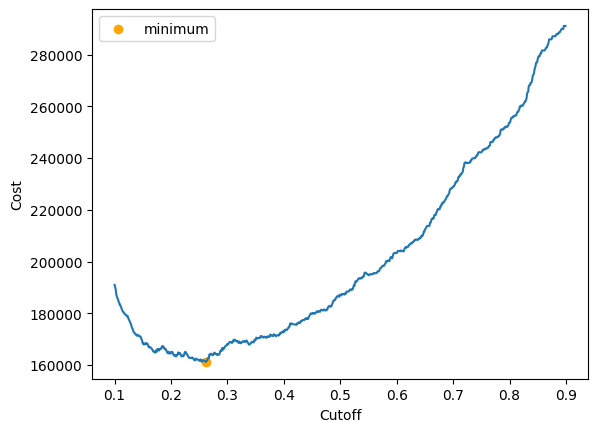

Cost is minimized near a cutoff of: 0.2620000000000001 for a cost of: 161200


In [ ]:
cutoffs = np.arange(0.1, .9, 0.001)

costs = []
for c in cutoffs:
    m = pd.crosstab(index=df_test['Exited'], columns=np.where(df_test['prob'] > float(c), 1, 0))
    costs.append(np.sum(np.sum(np.array([[0, 100], [500, 100]]) * m)))

costs = np.array(costs)
min_x = cutoffs[np.argmin(costs)]
min_y = np.min(costs)

plt.plot(cutoffs, costs)
plt.scatter(min_x, min_y, c='orange', label='minimum')
plt.legend()
plt.ylabel('Cost')
plt.xlabel('Cutoff')
plt.show()

print('Cost is minimized near a cutoff of:', min_x, 'for a cost of:', min_y)

In [ ]:
# Save encoder and scaler
pickle.dump(scaler, open('scaler.pkl','wb'))
pickle.dump(encoder, open('encoder.pkl','wb'))

In [ ]:
# Load encoder and scaler
scaler = pickle.load(open('scaler.pkl', 'rb'))
encoder = pickle.load(open('encoder.pkl', 'rb'))

In [ ]:
scale_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'EstimatedSalary', 'avg_transaction_amt',
       'credit_card_age', 'balance_to_salary_ratio', 'product_diversity',
       'age_squared', 'balance_credit_ratio', 'product_per_tenure',
       'credit_card_utilization', 'credit_score_age_ratio', 'log_balance',
       'log_salary']

X_test_loo = encoder.transform(X_val['Surname'], y_val)
X_val["Surname"] = X_test_loo

X_val[scale_cols] = scaler.transform(X_val[scale_cols])

In [ ]:
X_val.head()

In [ ]:
from collections import Counter
print('Resampled dataset shape %s' % Counter(y_tr))

Resampled dataset shape Counter({0: 5184, 1: 1426})


<Axes: >

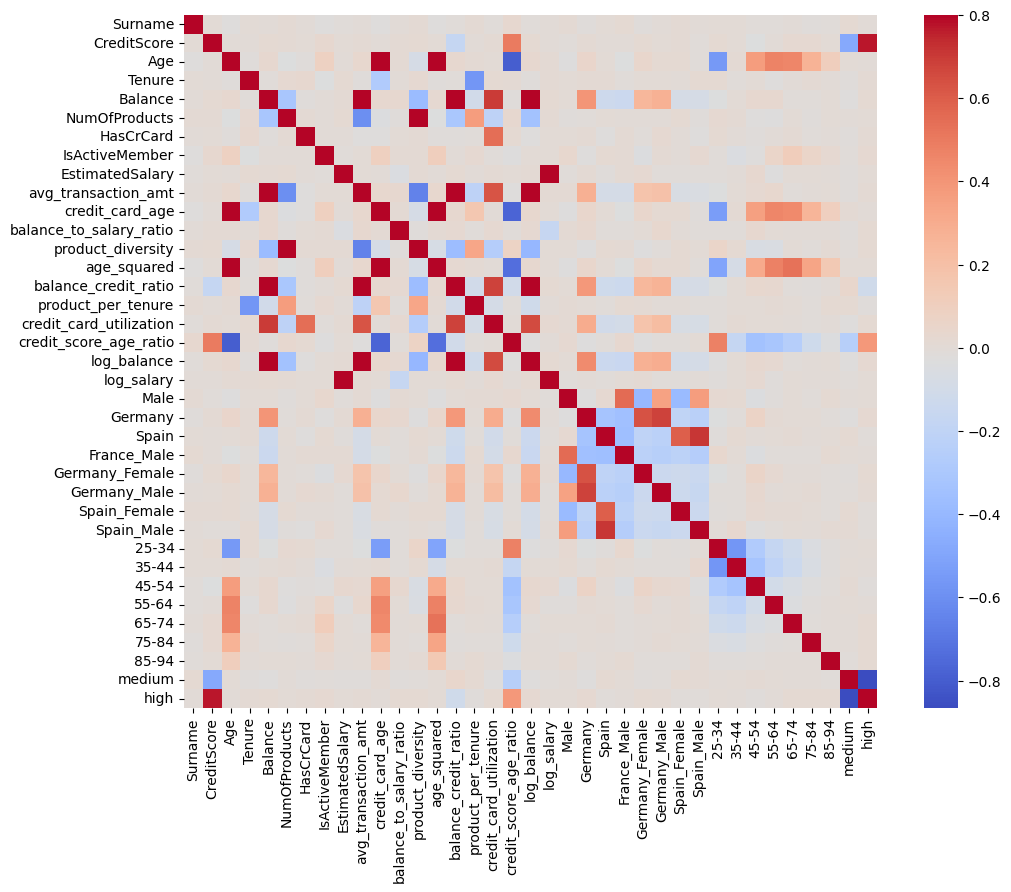

In [ ]:
import seaborn as sns

corrmat = X_tr.corr()
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(corrmat, vmax = 0.8, square = True, cmap = "coolwarm")

In [ ]:
X_tr.info()

# Minority Class Oversampling with GAN

In [ ]:
x_cols = list(X_tr.columns)
y_col = ["Exited"]

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
gan = GAN(num_epochs=200,
          batch_size=32,
          d_hidden_dim=(768, 512, 384, 256),
          g_hidden_dim=(1024, 768, 512, 384, 256, 128),
          n_input=len(x_cols + y_col),
          stddev=0.15,  # standard deviation for initialization noise
          d_learning_rate=0.001,
          g_learning_rate=0.00075,
          pretrain=False,
          random_state=SEED)

In [ ]:
Xf = X_tr.join(y_tr)

In [ ]:
gan.fit(Xf.loc[Xf['Exited'] == 1, x_cols + y_col].values, display_step=1)

Epoch: 1 loss_d_real: 0.2522 loss_d_fake: 0.0053 loss_g: 6.9296
Epoch: 2 loss_d_real: 0.0000 loss_d_fake: 0.0099 loss_g: 5.5482
Epoch: 3 loss_d_real: 0.0000 loss_d_fake: 0.0045 loss_g: 5.8855
Epoch: 4 loss_d_real: 0.0000 loss_d_fake: 0.0029 loss_g: 6.4503
Epoch: 5 loss_d_real: 0.0000 loss_d_fake: 0.0044 loss_g: 6.6540
Epoch: 6 loss_d_real: 0.0000 loss_d_fake: 0.0204 loss_g: 5.2714
Epoch: 7 loss_d_real: 0.0004 loss_d_fake: 0.0026 loss_g: 6.9448
Epoch: 8 loss_d_real: 0.0001 loss_d_fake: 0.0063 loss_g: 6.8059
Epoch: 9 loss_d_real: 2.0840 loss_d_fake: 0.0001 loss_g: 12.5371
Epoch: 10 loss_d_real: 0.0107 loss_d_fake: 0.0683 loss_g: 3.5500
Epoch: 11 loss_d_real: 0.0022 loss_d_fake: 0.3630 loss_g: 3.6536
Epoch: 12 loss_d_real: 0.0015 loss_d_fake: 0.2490 loss_g: 3.7988
Epoch: 13 loss_d_real: 0.0093 loss_d_fake: 0.4239 loss_g: 4.0388
Epoch: 14 loss_d_real: 0.0082 loss_d_fake: 0.5448 loss_g: 3.1194
Epoch: 15 loss_d_real: 0.0098 loss_d_fake: 0.3223 loss_g: 2.8010
Epoch: 16 loss_d_real: 0.0001 los

In [ ]:
synth_samples = pd.DataFrame(gan.sample(round((len(Xf.index) - sum(Xf['Exited']))/2)), columns = x_cols + y_col)

In [ ]:
synth_samples

In [ ]:
one_hot_cols = list(set(list(Xf.columns)).difference(scale_cols))

In [ ]:
one_hot_cols.remove("Surname")

In [ ]:
synth_samples[one_hot_cols] = synth_samples[one_hot_cols].apply(round).astype('int')

In [ ]:
synth_samples

# CatBoost Model + Hyperparameter tuning 

In [ ]:
from optuna.integration import CatBoostPruningCallback

optuna.logging.set_verbosity(optuna.logging.CRITICAL)


def objective(trial, X, y):
    param_grid = {
        "iterations": trial.suggest_int("iterations", 800, 8000),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.005, 0.1),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.2),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "depth": trial.suggest_int("depth", 4, 12),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0, 7, step=0.05),
        "random_strength": trial.suggest_float("random_strength", 0, 10),
    }

    if param_grid["bootstrap_type"] == "Bayesian":
      param_grid["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 5)
    elif param_grid["bootstrap_type"] == "Bernoulli":
      param_grid["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    # if param_grid["objective"]=="Logloss":
    #   param_grid["scale_pos_weight"] = trial.suggest_categorical("scale_pos_weight", [3.909])
    # else:
    #   param_grid["scale_pos_weight"] = None

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = cb.CatBoostClassifier(eval_metric='AUC', 
                                      od_wait=20, 
                                      od_type='Iter', 
                                      allow_writing_files = False,
                                      random_seed=SEED,
                                      #class_weights=weights,
                                      **param_grid)
        
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            #cat_features=categorical_features_indices,
            early_stopping_rounds=100,
            verbose=100,
            use_best_model=True,
            callbacks=[CatBoostPruningCallback(trial, 'AUC')],
        )
        preds = model.predict(X_test)
        cv_scores[idx] = roc_auc_score(y_test, preds)

    return np.mean(cv_scores)

In [ ]:
over = synth_samples.loc[synth_samples['Exited'] == 1, x_cols + y_col]

new = pd.concat([Xf, over])
new = new.sample(frac = 1)

In [ ]:
train = new.iloc[:,:-1]
target = new['Exited']

In [ ]:
X_tr = train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_tr = target.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

In [ ]:
study = optuna.create_study(direction="maximize", study_name="CatBoost Classifier")
func = lambda trial: objective(trial, X_tr, y_tr)
study.optimize(func, n_trials=10)

0:	test: 0.8182143	best: 0.8182143 (0)	total: 179ms	remaining: 15m 2s
100:	test: 0.9543363	best: 0.9545462 (86)	total: 5.92s	remaining: 4m 50s
200:	test: 0.9556125	best: 0.9567675 (138)	total: 9.48s	remaining: 3m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9567675125
bestIteration = 138

Shrink model to first 139 iterations.
0:	test: 0.8199642	best: 0.8199642 (0)	total: 120ms	remaining: 10m 8s
100:	test: 0.9503315	best: 0.9505414 (88)	total: 4.15s	remaining: 3m 23s
200:	test: 0.9490194	best: 0.9511291 (112)	total: 11.7s	remaining: 4m 41s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9511291182
bestIteration = 112

Shrink model to first 113 iterations.
0:	test: 0.8777109	best: 0.8777109 (0)	total: 107ms	remaining: 8m 58s
100:	test: 0.9561901	best: 0.9562369 (98)	total: 4.85s	remaining: 3m 58s
200:	test: 0.9556088	best: 0.9573706 (120)	total: 10.1s	remaining: 4m 2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.957

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 10
Best trial:
  Value: 0.8944600956265907
  Params: 
    iterations: 5053
    colsample_bylevel: 0.06082243439961702
    learning_rate: 0.1344356594265969
    boosting_type: Ordered
    bootstrap_type: MVS
    depth: 11
    l2_leaf_reg: 0.7000000000000001
    random_strength: 4.714086691354719


In [ ]:
cat_score = []

# Split data with kfold
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
train_features = X_tr.columns
# Make importance dataframe
importances = pd.DataFrame()

oof_preds = np.zeros(X_tr.shape[0])
sub_preds = np.zeros(X_val.shape[0])

for n_fold, (trn_idx, val_idx) in enumerate(kfolds.split(X_tr, y_tr)):
    X_train, y_train = X_tr.iloc[trn_idx], y_tr.iloc[trn_idx]
    X_valid, y_valid = X_tr.iloc[val_idx], y_tr.iloc[val_idx]

    # CatBoost Classification
    model = cb.CatBoostClassifier(
        eval_metric = 'AUC',
        allow_writing_files = False,
        od_type = 'Iter',
        od_wait = 20,
        silent = False,
        **trial.params
    )


    # Fit
    model.fit(
        X_train, y_train,
        #cat_features=categorical_features_indices,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=100,
        early_stopping_rounds=100
    )
    
    # Feature importance
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = model.get_feature_importance()
    imp_df['fold'] = n_fold + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_preds[val_idx] = model.predict_proba(X_valid)[:, 1]
    cat_score.append(roc_auc_score(y_valid, oof_preds[val_idx]))
    test_preds = model.predict_proba(X_val)[:, 1]
    sub_preds += test_preds / kfolds.n_splits
    
print(np.mean(cat_score))

0:	test: 0.7520682	test1: 0.7729074	best: 0.7729074 (0)	total: 12.6ms	remaining: 1m 3s
100:	test: 0.9796799	test1: 0.9562242	best: 0.9562314 (98)	total: 4.46s	remaining: 3m 38s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9562313793
bestIteration = 98

Shrink model to first 99 iterations.
0:	test: 0.7489665	test1: 0.7507772	best: 0.7507772 (0)	total: 19.4ms	remaining: 1m 38s
100:	test: 0.9787550	test1: 0.9507801	best: 0.9509252 (91)	total: 5.14s	remaining: 4m 11s
200:	test: 0.9874367	test1: 0.9499717	best: 0.9517912 (138)	total: 9.54s	remaining: 3m 50s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9517911887
bestIteration = 138

Shrink model to first 139 iterations.
0:	test: 0.7994079	test1: 0.8062803	best: 0.8062803 (0)	total: 17.4ms	remaining: 1m 28s
100:	test: 0.9757215	test1: 0.9579002	best: 0.9579002 (100)	total: 3.74s	remaining: 3m 3s
200:	test: 0.9831579	test1: 0.9585859	best: 0.9589257 (117)	total: 10.8s	remaining: 4m 19s
300:	test

In [ ]:
importances

In [ ]:
# Save final Model
pickle.dump(model, open('model.pkl','wb'))

In [ ]:
# Load Model
model = pickle.load(open('model.pkl', 'rb'))

In [ ]:
model.get_params()

In [ ]:
pred = model.predict_proba(X_val)

In [ ]:
thresh = 0.30600000000000016   #V1 thresh = 0.2170000000000001

In [ ]:
pred = (pred[:,1] > thresh)

In [ ]:
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.94      0.88      0.90      2389
           1       0.61      0.76      0.68       611

    accuracy                           0.85      3000
   macro avg       0.77      0.82      0.79      3000
weighted avg       0.87      0.85      0.86      3000



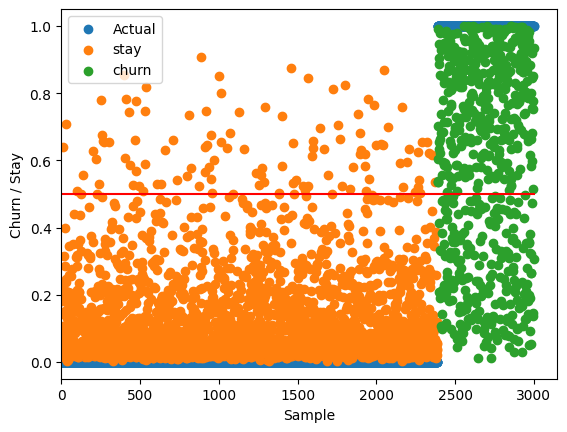

In [ ]:
pred = model.predict_proba(X_val)
df_test = X_val.join(y_val)
df_test['prob'] = pred[:,1]

df = df_test.sort_values('Exited')
df = df.reset_index(drop=True)

stay = df[df['Exited']==0]
churn = df[df['Exited']==1]

m = pd.crosstab(index=df_test['Exited'], columns=np.where(df_test['prob'] > thresh, 1, 0))
cost = (np.sum(np.sum(np.array([[0, 100], [500, 100]]) * m)))

plt.figure()
plt.scatter(df.index,df['Exited'],label='Actual')
plt.scatter(stay.index,stay['prob'],label='stay')
plt.scatter(churn.index,churn['prob'],label='churn')
plt.plot([df.index.min(),df.index.max()],[0.5,0.5],color='r')
plt.xlim(left=0)
plt.xlabel('Sample')
plt.ylabel('Churn / Stay')
plt.legend(loc=2)
plt.show()

# Finding the optimal probability threshold
In churn problems, false negatives are substantially more costly than false positives. Instead of optimizing for AUC or F1, its better to minimize a cost function that accounts for the lifetime loss of losing a customer and what its costs to retain them. Assuming we lose out on a potential \\$500 over the lifetime of a customer and that we are willing to spend $100 to retain them, we have:

\

$ Cost = \$500*FN(C) + \$0*TN(C) + \$100*FP(C) + \$100*TP(C) $

\

FN(C) means that the false negative percentage is a function of the cutoff, C, and similar for TN, FP, and TP. We need to find the cutoff, C, where the result of the expression is minimized.

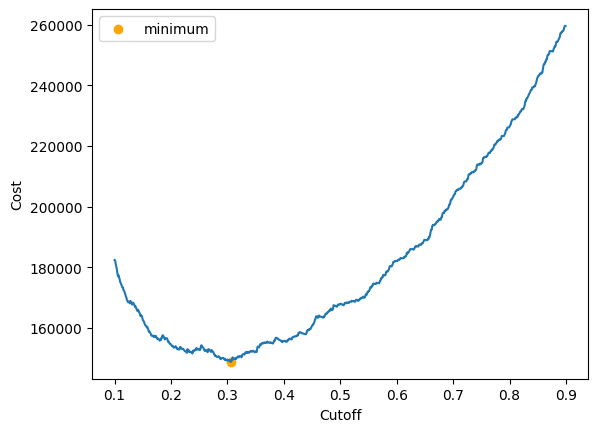

Cost is minimized near a cutoff of: 0.30600000000000016 for a cost of: 148800


In [ ]:
cutoffs = np.arange(0.1, .9, 0.001)

costs = []
for c in cutoffs:
    m = pd.crosstab(index=df_test['Exited'], columns=np.where(df_test['prob'] > float(c), 1, 0))
    costs.append(np.sum(np.sum(np.array([[0, 100], [500, 100]]) * m)))

costs = np.array(costs)
min_x = cutoffs[np.argmin(costs)]
min_y = np.min(costs)

plt.plot(cutoffs, costs)
plt.scatter(min_x, min_y, c='orange', label='minimum')
plt.legend()
plt.ylabel('Cost')
plt.xlabel('Cutoff')
plt.show()

print('Cost is minimized near a cutoff of:', min_x, 'for a cost of:', min_y)